In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import itertools
import time
import warnings
from collections import Counter
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

2025-05-20 12:54:27.325941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747745667.656520     116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747745667.751448     116 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (255, 255)
BATCH_SIZE = 32

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def normalize_image(img):
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    return img

def random_rotate(image):
    k = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)
    return tf.image.rot90(image, k)

def preprocess_train(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = random_rotate(image) 
    image = normalize_image(image)
    return image, label

def preprocess_eval(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = normalize_image(image)
    return image, label

In [3]:
for dirname, _, _ in os.walk("/kaggle/input"):
    print(dirname)

/kaggle/input
/kaggle/input/diagnosis-of-diabetic-retinopathy
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid/No_DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test/No_DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/DR
/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/No_DR
/kaggle/input/diagnosis-of-diabetic-reti

In [4]:
data_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy"

train_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_train).shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_eval).prefetch(tf.data.AUTOTUNE)

test_set = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
).map(preprocess_eval).prefetch(tf.data.AUTOTUNE)

Found 2076 files belonging to 2 classes.


2025-05-20 12:54:48.712698: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 531 files belonging to 2 classes.
Found 231 files belonging to 2 classes.


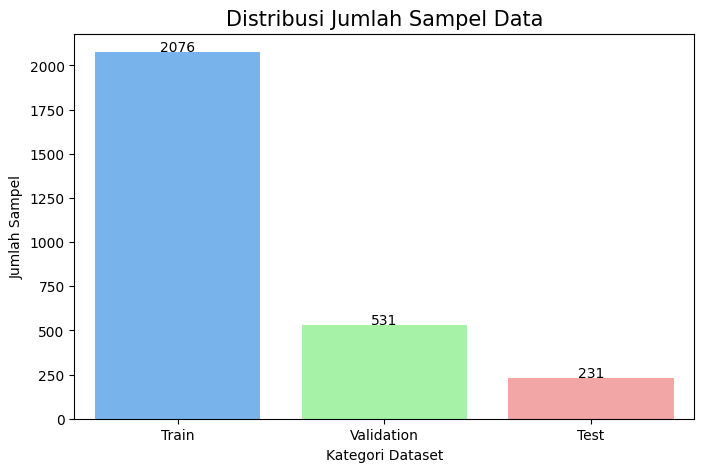

In [5]:
def total_samples(dataset):
    total = 0
    for images, labels in dataset:
        total += images.shape[0]
    return total
categories = ['Train', 'Validation', 'Test']
colors = ['#66b3ff', '#99ff99', '#ff9999']
counts_samples = [total_samples(train_set), total_samples(val_set), total_samples(test_set)]

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=counts_samples, palette=colors)
plt.title('Distribusi Jumlah Sampel Data', fontsize=15)
plt.xlabel('Kategori Dataset')
plt.ylabel('Jumlah Sampel')
for i, count in enumerate(counts_samples):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()

Found 2076 files belonging to 2 classes.


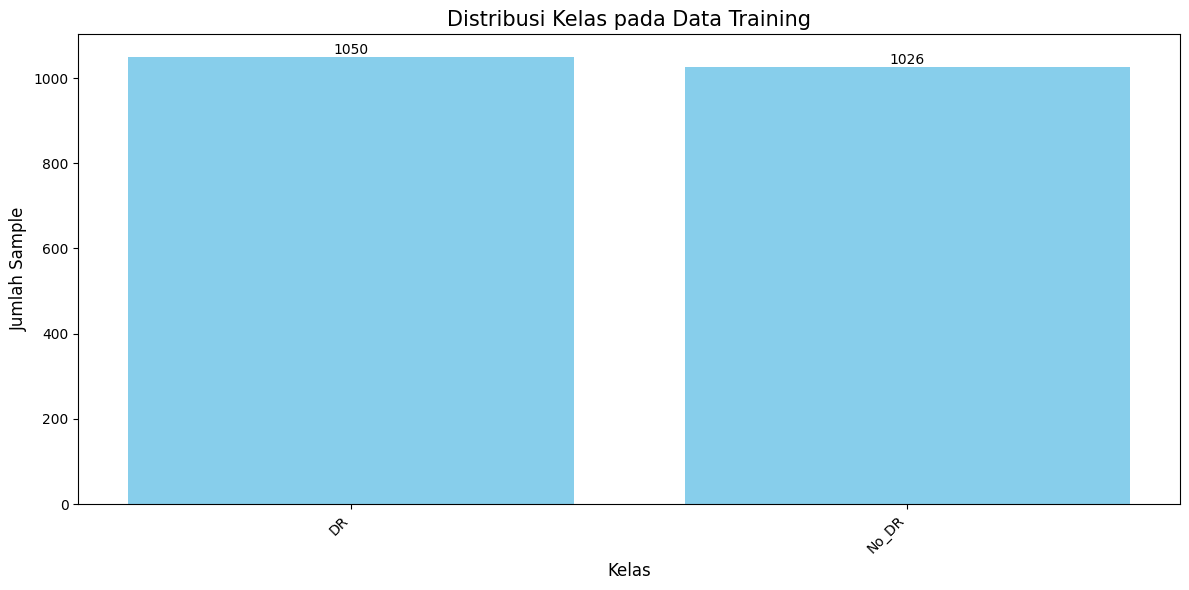

In [6]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)
class_names = raw_train_ds.class_names

all_labels = []
for _, labels in raw_train_ds.unbatch():
    all_labels.append(int(labels.numpy()))

class_counts = Counter(all_labels)

class_names_sorted = [class_names[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names_sorted, counts, color='skyblue')

plt.title('Distribusi Kelas pada Data Training', fontsize=15)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Sample', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

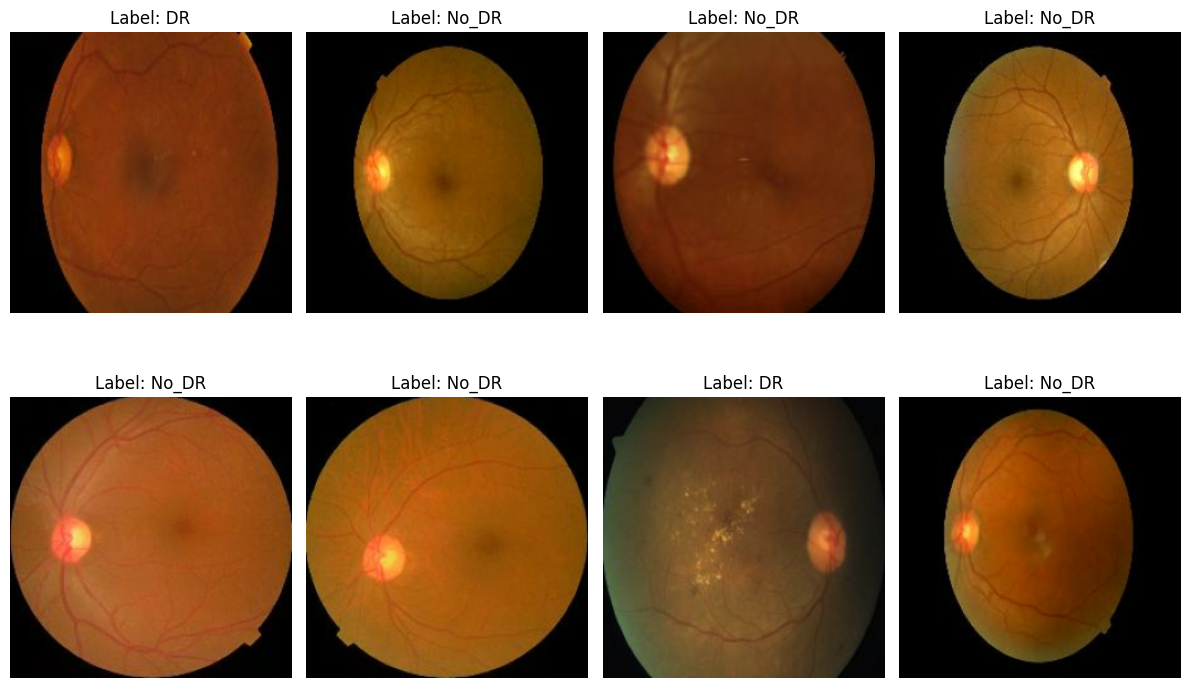

In [7]:
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    return np.clip(img, 0, 1)

plt.figure(figsize=(12, 8))

for images, labels in train_set.take(1):
    images = images.numpy()
    labels = labels.numpy()

    for i in range(8):
        img = denormalize(images[i])
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
# Load pretrained DenseNet121 base model (tanpa top)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(255, 255, 3))

# Freeze base model for initial training
base_model.trainable = False

# Tambahkan RCNN-like detection head
model = models.Sequential([
    base_model,
    layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'),  # RCNN-like head
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # Ganti 2 dengan jumlah kelas
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 256)           │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,397,570 (35.85 MB)

 Trainable params: 2,360,066 (9.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# Jalankan training
history = model.fit(
    train_set,               # Dataset training
    validation_data=val_set, # Dataset validasi
    epochs=30,               # Jumlah epoch training
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 404s 6s/step - accuracy: 0.5263 - loss: 0.7233 - val_accuracy: 0.7156 - val_loss: 0.6303 - learning_rate: 0.0010
Epoch 2/30
10/65 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 0.6613 - loss: 0.6482

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss selama training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Akurasi selama training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
y_true = []
y_pred = []

for images, labels in val_set:   
    preds = model.predict(images)
    preds_labels = preds.argmax(axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels)

print(classification_report(y_true, y_pred))

f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1-score (macro): {f1:.4f}")